# The flexible interface

In the previous tutorial, we have demonstrated how `sbi` can be used to run simulation-based inference with just a single line of code.

In addition to this simple interface, `sbi` also provides a **flexible interface** which provides several additional features implemented in `sbi`.

Note, you can find the original version of this notebook at [https://github.com/sbi-dev/sbi/blob/main/tutorials/02_flexible_interface.ipynb](https://github.com/sbi-dev/sbi/blob/main/tutorials/02_flexible_interface.ipynb) in the `sbi` repository.

## Features

The flexible interface offers the following features (and many more):

- performing sequential posterior estimation by focusing on a particular observation over multiple rounds. This can decrease the number of simulations one has to run, but the inference procedure is no longer amortized ([tutorial](https://sbi-dev.github.io/sbi/tutorial/03_multiround_inference/)).    
- specify your own density estimator, or change hyperparameters of existing ones (e.g. number of hidden units for [NSF](https://arxiv.org/abs/1906.04032)) ([tutorial](https://www.mackelab.org/sbi/tutorial/04_density_estimators/)).    
- use an `embedding_net` to learn summary features from high-dimensional simulation outputs ([tutorial](https://www.mackelab.org/sbi/tutorial/05_embedding_net/)).  
- provide presimulated data  
- choose between different methods to sample from the posterior.  
- use calibration kernels as proposed by [Lueckmann, Goncalves et al. 2017](https://arxiv.org/abs/1711.01861).

## Main syntax

```Python
from sbi.utils.user_input_checks import process_prior, process_simulator, check_sbi_inputs
from sbi.inference import SNPE, simulate_for_sbi

prior, num_parameters, prior_returns_numpy = process_prior(prior)
simulator = process_simulator(simulator, prior, prior_returns_numpy)
check_sbi_inputs(simulator, prior)
inference = SNPE(prior)

theta, x = simulate_for_sbi(simulator, proposal=prior, num_simulations=1000)
density_estimator = inference.append_simulations(theta, x).train()
posterior = inference.build_posterior(density_estimator)
```

## Linear Gaussian example

We will show an example of how we can use the flexible interface to infer the posterior for an example with a Gaussian likelihood (same example as before). First, we import the inference method we want to use (`SNPE`, `SNLE`, or `SNRE`) and other helper functions.

In [1]:
import torch

from sbi import analysis as analysis
from sbi import utils as utils
from sbi.inference import SNPE, simulate_for_sbi
from sbi.utils.user_input_checks import (
    check_sbi_inputs,
    process_prior,
    process_simulator,
)

Next, we define the prior and simulator:

In [2]:
num_dim = 3
prior = utils.BoxUniform(low=-2 * torch.ones(num_dim), high=2 * torch.ones(num_dim))

In [3]:
def linear_gaussian(theta):
    return theta + 1.0 + torch.randn_like(theta) * 0.1

In the flexible interface, you have to ensure that your simulator and prior adhere to the requirements of `sbi`. You can do so with the `process_simulator()` and `process_prior()` functions, which prepare them appropriately. Finally, you can call `check_sbi_input()` to make sure they are consistent which each other.

In [4]:
# Check prior, return PyTorch prior.
prior, num_parameters, prior_returns_numpy = process_prior(prior)

# Check simulator, returns PyTorch simulator able to simulate batches.
simulator = process_simulator(linear_gaussian, prior, prior_returns_numpy)

# Consistency check after making ready for sbi.
check_sbi_inputs(simulator, prior)

Then, we instantiate the inference object:

In [5]:
inference = SNPE(prior=prior)

Next, we run simulations. You can do so either by yourself by sampling from the prior and running the simulator (e.g. on a compute cluster), or you can use a helper function provided by `sbi` called `simulate_for_sbi`. This function allows to parallelize your code with `joblib`.

In [6]:
theta, x = simulate_for_sbi(simulator, proposal=prior, num_simulations=2000)

Running 2000 simulations.:   0%|          | 0/2000 [00:00<?, ?it/s]

We then pass the simulated data to the inference object. `theta` and `x` should both be a `torch.Tensor` of type `float32`.

In [7]:
inference = inference.append_simulations(theta, x)

Next, we train the neural density estimator.

In [8]:
density_estimator = inference.train()

 Neural network successfully converged after 124 epochs.

Lastly, we can use this density estimator to build the posterior:

In [9]:
posterior = inference.build_posterior(density_estimator)

Once we have obtained the posterior, we can `.sample()`, `.log_prob()`, or `.pairplot()` in the same way as for the simple interface.

In [10]:
x_o = torch.zeros(3,)

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

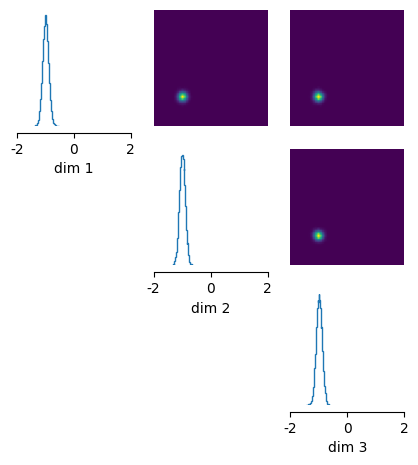

In [11]:
posterior_samples = posterior.sample((10000,), x=x_o)

# plot posterior samples
_ = analysis.pairplot(
    posterior_samples, limits=[[-2, 2], [-2, 2], [-2, 2]], figsize=(5, 5)
)

We can always print the posterior to know how it was trained:

In [12]:
print(posterior)

Posterior conditional density p(θ|x) of type DirectPosterior. It samples the posterior network and rejects samples that
            lie outside of the prior bounds.
